#Load Dataset

In [46]:
# from google.colab import userdata
# import os
# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# !kaggle datasets download -d muhammad4hmed/monkeypox-patients-dataset
# #if alr exist
# !rm "DATA.csv"

# !unzip "monkeypox-patients-dataset.zip"
# !rm "monkeypox-patients-dataset.zip"

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve

In [48]:
df = pd.read_csv("DATA.csv")
df

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,P0,None,False,True,True,True,False,True,False,False,Negative
1,P1,Fever,True,False,True,True,False,False,True,False,Positive
2,P2,Fever,False,True,True,False,False,False,True,False,Positive
3,P3,None,True,False,False,False,True,True,True,False,Positive
4,P4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,Positive
...,...,...,...,...,...,...,...,...,...,...,...
24995,P24995,None,True,True,False,True,True,False,False,True,Positive
24996,P24996,Fever,False,True,True,False,True,True,True,True,Positive
24997,P24997,None,True,True,False,False,True,True,False,False,Positive
24998,P24998,Swollen Lymph Nodes,False,True,False,True,True,True,False,False,Negative


#EDA #1

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Patient_ID                      25000 non-null  object
 1   Systemic Illness                25000 non-null  object
 2   Rectal Pain                     25000 non-null  bool  
 3   Sore Throat                     25000 non-null  bool  
 4   Penile Oedema                   25000 non-null  bool  
 5   Oral Lesions                    25000 non-null  bool  
 6   Solitary Lesion                 25000 non-null  bool  
 7   Swollen Tonsils                 25000 non-null  bool  
 8   HIV Infection                   25000 non-null  bool  
 9   Sexually Transmitted Infection  25000 non-null  bool  
 10  MonkeyPox                       25000 non-null  object
dtypes: bool(8), object(3)
memory usage: 781.4+ KB


In [50]:
df.describe()

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
count,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000
unique,25000,4,2,2,2,2,2,2,2,2,2
top,P0,Fever,False,True,True,False,True,True,True,False,Positive
freq,1,6382,12655,12554,12612,12514,12527,12533,12584,12554,15909


In [51]:
df['MonkeyPox'].value_counts(dropna=False)

Positive    15909
Negative     9091
Name: MonkeyPox, dtype: int64

In [52]:
df.isnull().sum()

Patient_ID                        0
Systemic Illness                  0
Rectal Pain                       0
Sore Throat                       0
Penile Oedema                     0
Oral Lesions                      0
Solitary Lesion                   0
Swollen Tonsils                   0
HIV Infection                     0
Sexually Transmitted Infection    0
MonkeyPox                         0
dtype: int64

#Preprocess

In [53]:
#Handle missing values by dropping it
# df = df.dropna()

#NaN means no systemic illness (but there is still possibility for people to have the monkeypox)
df.fillna('None', inplace=True)

In [54]:
# df = df.sample(15000)
# df.reset_index(inplace=True, drop=True)
# df

In [55]:
df.isnull().sum()

Patient_ID                        0
Systemic Illness                  0
Rectal Pain                       0
Sore Throat                       0
Penile Oedema                     0
Oral Lesions                      0
Solitary Lesion                   0
Swollen Tonsils                   0
HIV Infection                     0
Sexually Transmitted Infection    0
MonkeyPox                         0
dtype: int64

In [56]:
df['MonkeyPox'].value_counts(dropna=False)

Positive    15909
Negative     9091
Name: MonkeyPox, dtype: int64

In [57]:
#drop unnecessary column
df = df.drop(['Patient_ID'], axis = 1)

In [58]:
print(df.columns)

Index(['Systemic Illness', 'Rectal Pain', 'Sore Throat', 'Penile Oedema',
       'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection',
       'Sexually Transmitted Infection', 'MonkeyPox'],
      dtype='object')


In [59]:
#Encode categorical feature
label_encoder = LabelEncoder()
df['MonkeyPox'] = label_encoder.fit_transform(df['MonkeyPox'])

df.head()

,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,None,False,True,True,True,False,True,False,False,0
1,Fever,True,False,True,True,False,False,True,False,1
2,Fever,False,True,True,False,False,False,True,False,1
3,None,True,False,False,False,True,True,True,False,1
4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,1


Text(0.5, 1.0, 'MonkeyPox Porbability by Systemic Illness')

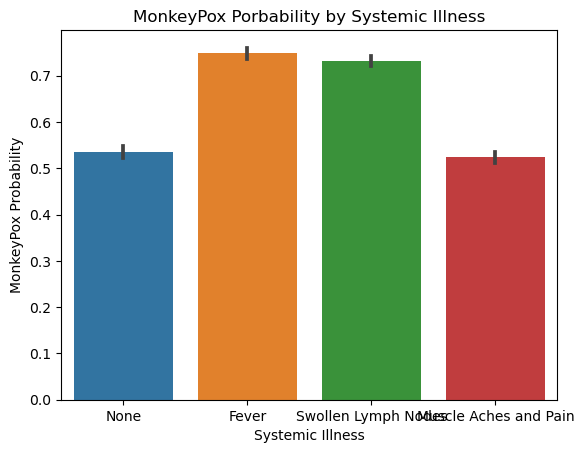

In [60]:
sns.barplot(x = 'Systemic Illness', y = 'MonkeyPox', data = df)
plt.ylabel('MonkeyPox Probability')
plt.title('MonkeyPox Porbability by Systemic Illness')

In [61]:
#One Hot Encoding Systemic Illness
df = pd.get_dummies(df, columns=['Systemic Illness'], drop_first=False)

In [62]:
df.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_None,Systemic Illness_Swollen Lymph Nodes
0,False,True,True,True,False,True,False,False,0,0,0,1,0
1,True,False,True,True,False,False,True,False,1,1,0,0,0
2,False,True,True,False,False,False,True,False,1,1,0,0,0
3,True,False,False,False,True,True,True,False,1,0,0,1,0
4,True,True,True,False,False,True,True,False,1,0,0,0,1


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Rectal Pain                             25000 non-null  bool 
 1   Sore Throat                             25000 non-null  bool 
 2   Penile Oedema                           25000 non-null  bool 
 3   Oral Lesions                            25000 non-null  bool 
 4   Solitary Lesion                         25000 non-null  bool 
 5   Swollen Tonsils                         25000 non-null  bool 
 6   HIV Infection                           25000 non-null  bool 
 7   Sexually Transmitted Infection          25000 non-null  bool 
 8   MonkeyPox                               25000 non-null  int32
 9   Systemic Illness_Fever                  25000 non-null  uint8
 10  Systemic Illness_Muscle Aches and Pain  25000 non-null  uint8
 11  Systemic Illnes

In [64]:
#Convert bool to int
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Rectal Pain                             25000 non-null  int32
 1   Sore Throat                             25000 non-null  int32
 2   Penile Oedema                           25000 non-null  int32
 3   Oral Lesions                            25000 non-null  int32
 4   Solitary Lesion                         25000 non-null  int32
 5   Swollen Tonsils                         25000 non-null  int32
 6   HIV Infection                           25000 non-null  int32
 7   Sexually Transmitted Infection          25000 non-null  int32
 8   MonkeyPox                               25000 non-null  int32
 9   Systemic Illness_Fever                  25000 non-null  uint8
 10  Systemic Illness_Muscle Aches and Pain  25000 non-null  uint8
 11  Systemic Illnes

In [66]:
df

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_None,Systemic Illness_Swollen Lymph Nodes
0,0,1,1,1,0,1,0,0,0,0,0,1,0
1,1,0,1,1,0,0,1,0,1,1,0,0,0
2,0,1,1,0,0,0,1,0,1,1,0,0,0
3,1,0,0,0,1,1,1,0,1,0,0,1,0
4,1,1,1,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1,1,0,1,1,0,0,1,1,0,0,1,0
24996,0,1,1,0,1,1,1,1,1,1,0,0,0
24997,1,1,0,0,1,1,0,0,1,0,0,1,0
24998,0,1,0,1,1,1,0,0,0,0,0,0,1


#EDA #2

<AxesSubplot:>

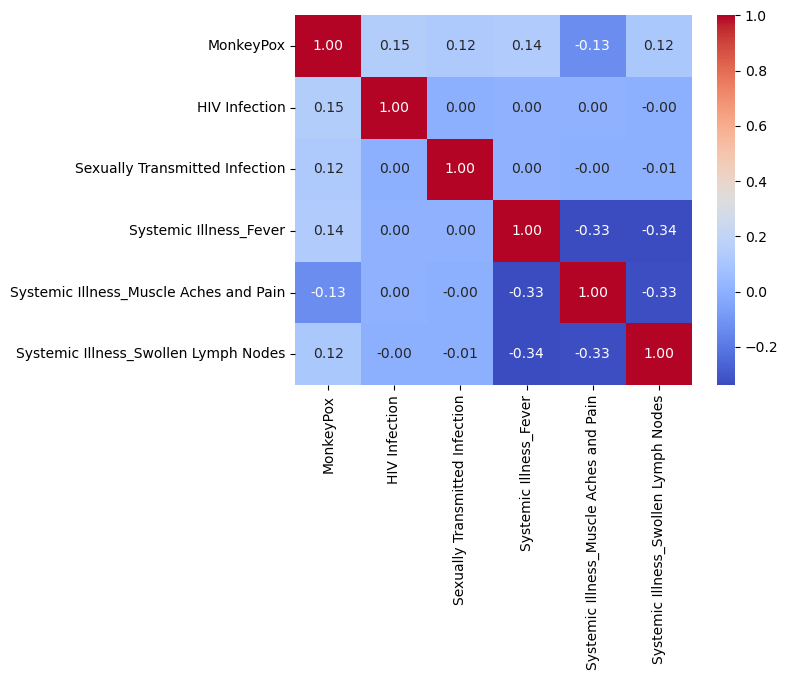

In [67]:
sns.heatmap(df[['MonkeyPox', 'HIV Infection', 'Sexually Transmitted Infection', 'Systemic Illness_Fever', 'Systemic Illness_Muscle Aches and Pain', 'Systemic Illness_Swollen Lymph Nodes']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

Text(0.5, 1.0, 'MonkeyPox Probability by Sexually Transmitted Infection')

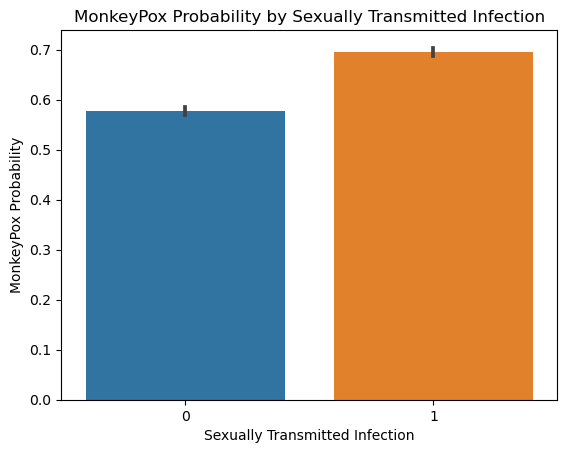

In [68]:
sns.barplot(x = 'Sexually Transmitted Infection', y = 'MonkeyPox', data = df)
plt.ylabel('MonkeyPox Probability')
plt.title('MonkeyPox Probability by Sexually Transmitted Infection')

#SPLIT DATASET

In [69]:
X = df.drop('MonkeyPox', axis = 1)
y = df['MonkeyPox']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [70]:
print(X)

       Rectal Pain  Sore Throat  Penile Oedema  Oral Lesions  Solitary Lesion  \
0                0            1              1             1                0   
1                1            0              1             1                0   
2                0            1              1             0                0   
3                1            0              0             0                1   
4                1            1              1             0                0   
...            ...          ...            ...           ...              ...   
24995            1            1              0             1                1   
24996            0            1              1             0                1   
24997            1            1              0             0                1   
24998            0            1              0             1                1   
24999            0            0              1             0                0   

       Swollen Tonsils  HIV

In [71]:
# Check class distribution
print("Training set class distribution:\n", y_train.value_counts())
print("\nTest set class distribution:\n", y_test.value_counts())

Training set class distribution:
 1    11102
0     6398
Name: MonkeyPox, dtype: int64

Test set class distribution:
 1    4807
0    2693
Name: MonkeyPox, dtype: int64


In [72]:
print(X_test.values)

[[1 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 1]
 [1 1 0 ... 0 1 0]
 ...
 [0 0 1 ... 0 1 0]
 [0 1 1 ... 1 0 0]
 [1 1 1 ... 0 0 1]]


In [73]:
def save_model(model, name):
  file = open(name+'.pickle', "wb")
  pkl.dump(model, file)
  file.close()

def model_evaluation(model_name, y_test, predictions):
  accuracy = accuracy_score(y_test, predictions)
  precision = precision_score(y_test, predictions)
  recall = recall_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  print(f"========= {model_name.upper()} EVALUATION =========")
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("f1_score:", f1)

  print()
  cm = confusion_matrix(y_test, predictions)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
  cm_display.plot()
  plt.show()

  # print()
  # fpr, tpr, thresholds = roc_curve(y_test, predictions)
  # plt.figure(figsize=(9, 6))
  # plt.plot(fpr, tpr, label='ROC curve')
  # plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver Operating Characteristic Curve')
  # plt.legend()
  # plt.show()

[00:01:43] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\wilbe\miniconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


========= XGBOOST CLASSIFIER EVALUATION =========
Accuracy: 0.6926666666666667
Precision: 0.7099697885196374
Recall: 0.8799667152069898
f1_score: 0.785880167208546



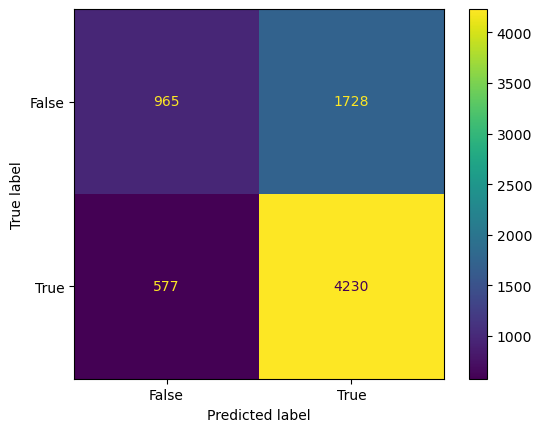

In [74]:
XGBOOST_MODEL = XGBClassifier()
XGBOOST_MODEL.fit(X_train.values, y_train)
pred = XGBOOST_MODEL.predict(X_test.values)
model_evaluation("XGBOOST CLASSIFIER", y_test, pred)


========= DECISION TREE EVALUATION =========
Accuracy: 0.6814666666666667
Precision: 0.7155848787446505
Recall: 0.8348242146869149
f1_score: 0.7706192990878541



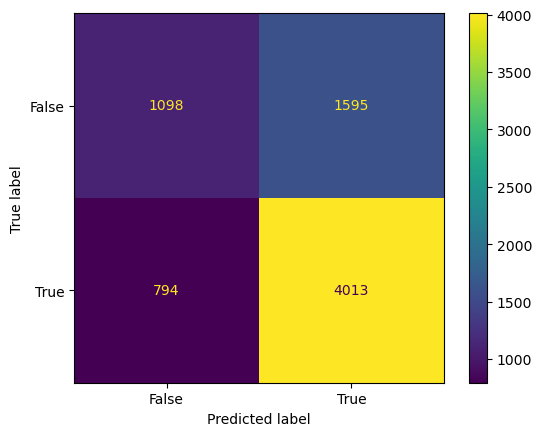

In [75]:
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
pred = DecisionTree.predict(X_test)
model_evaluation("Decision Tree", y_test, pred)

========= RANDOM FOREST EVALUATION =========
Accuracy: 0.6834666666666667
Precision: 0.7127120125896136
Recall: 0.8479301019346785
f1_score: 0.7744632338970169



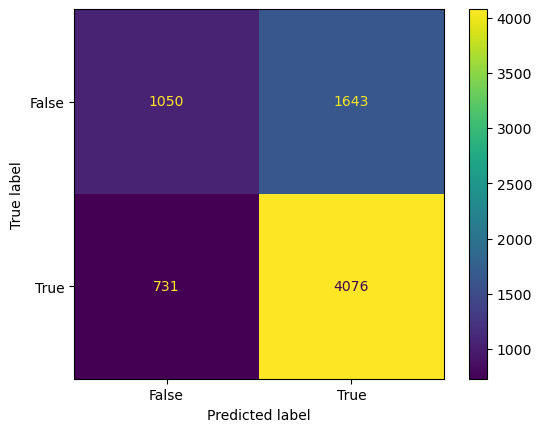

In [76]:
RandomForest = RandomForestClassifier(n_estimators= 1000, random_state=42)
RandomForest.fit(X_train, y_train)
pred = RandomForest.predict(X_test)
model_evaluation("Random Forest", y_test, pred)

========= SVM CLASSIFIER EVALUATION =========
Accuracy: 0.6974666666666667
Precision: 0.7070822454308094
Recall: 0.9013938007073019
f1_score: 0.7925011431184271



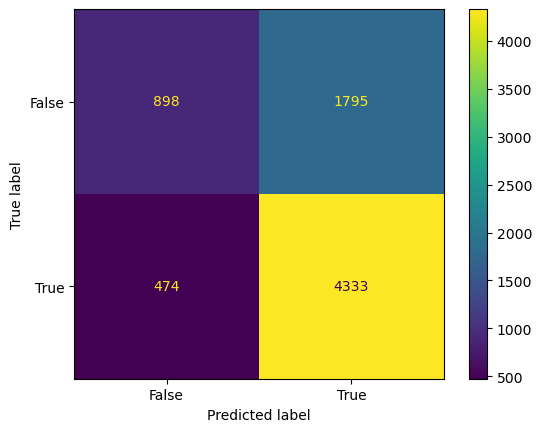

In [77]:
SVM = SVC()
SVM.fit(X_train, y_train)
pred = SVM.predict(X_test)
model_evaluation("SVM Classifier", y_test, pred)

========= NAIVE BAYES EVALUATION =========
Accuracy: 0.6704
Precision: 0.7463599915594007
Recall: 0.7358019554815893
f1_score: 0.7410433689503456



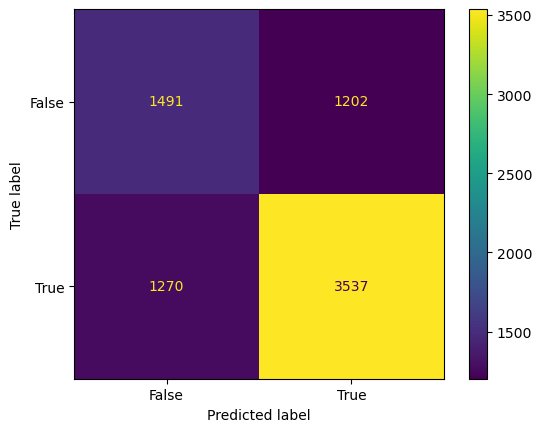

In [78]:
NaiveBayes = GaussianNB()
NaiveBayes.fit(X_train, y_train)
pred = NaiveBayes.predict(X_test)
model_evaluation("Naive Bayes", y_test, pred)

========= KNN EVALUATION =========
Accuracy: 0.6566666666666666
Precision: 0.7019543973941368
Recall: 0.8069482005408779
f1_score: 0.7507984128520275



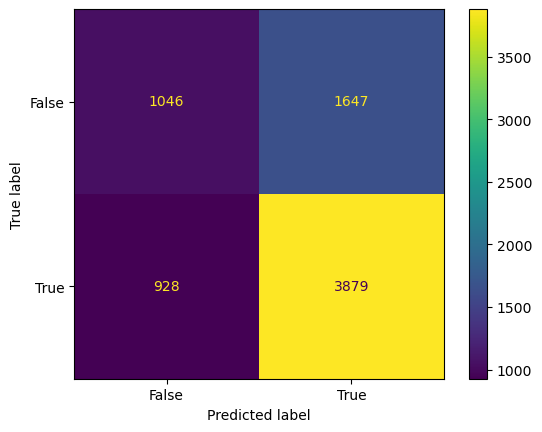

In [79]:
KNN = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 2)
KNN.fit(X_train, y_train)
pred = KNN.predict(X_test)
model_evaluation("KNN", y_test, pred)

========= LOGISTIC REGRESSION EVALUATION =========
Accuracy: 0.6953333333333334
Precision: 0.71771408839779
Recall: 0.864780528396089
f1_score: 0.7844136239267855



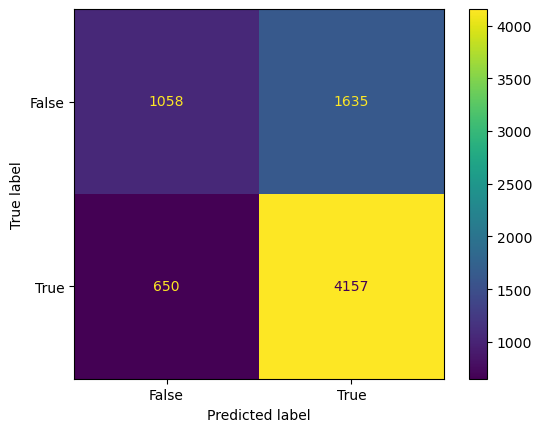

In [80]:
LogisticReg = LogisticRegression()
LogisticReg.fit(X_train, y_train)
pred = LogisticReg.predict(X_test)
model_evaluation("Logistic Regression", y_test, pred)

In [81]:
save_model(XGBOOST_MODEL, 'XGBOOST')

In [82]:
save_model(SVM,'SVM')

In [83]:
save_model(NaiveBayes, 'NB')